In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.svm import SVC
from sklearn.datasets import make_blobs, make_circles
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, train_test_split, GridSearchCV
from scipy.stats import multivariate_normal
import warnings
warnings.filterwarnings("ignore")
import seaborn as sb

# %matplotlib notebook
# plt.style.use('ggplot')

# TP n°2 : Support Vector Machine (SVM)

**Authors:** José Lucas Barretto and Lucas Miguel Celinga Agrizzi

## Preliminary questions

**1) Show that the primal problem solved by the SVM can be rewritten as follows :**

$$ \text{argmin}_{\mathbf{w} \in \mathcal{H}, w_0 \in \mathbb{R} } \left( \frac{1}{2}||\mathbf{w}||^2 + C \sum_{i=1}^n [ 1 - y_i ( \langle \mathbf{w}, \Phi(\mathbf{x_i}) \rangle + w_0 )]_+ \right) $$

We know that $\xi_i \geq 0$ and $y_i(<w,\phi(x_i)> + w_0) \geq 1 - \xi_i$. Thus, we know that:

$$
\xi_i \geq \max(0, 1 - y_i(<w,\phi(x_i)> + w_0))
$$

Which is equivalent to:

$$
\xi_i \geq [1 - y_i(<w,\phi(x_i)> + w_0)]_+
$$

Therefore, we can rewrite the original optimization, with no loss of generality, as:

$$
\text{argmin}_{\mathbf{w} \in \mathcal{H}, w_0 \in \mathbb{R} } \left( \frac{1}{2}||\mathbf{w}||^2 + C \sum_{i=1}^n [ 1 - y_i ( \langle \mathbf{w}, \Phi(\mathbf{x_i}) \rangle + w_0 )]_+ \right)
$$

**2) Explain the sentence : "an SVM minimizes the classification error using a convex upper bound". The function $x \rightarrow [1 - x]_+ = \text{max}(0, 1-x)$ is called *Hinge* (*charnière* en français). Explain the difference between the pivotal loss and the loss of binary classification.**

Normally the classifier tries to maximize the margin $w$. When you have a binary loss, you penalize the error with a error of size 1, independent of the distance/probability of the prediction of the model. The hinge loss uses the interval $|w|$ to penalizate the model, so if the prediction is *correct* but the inside the margin $|w|$ it's penalized with a value between 0 and 1 acording with the distance of the point to the hyperplane, if it's *wrong*, the model penalies with an error bigger than 1 proportional to the distance of the hyperplane. The equation that represent that is $Hinge_{loss} = max(0, 1 - t<w,x>)$ where t is the label of the point and $<w, x>$ is the distance of the point to the hyperplane.

The Hinge loss is continuous but not smooth, although, the function of the *Hinge loss has a subgradient, so we can apply the subgradient method to find the minimum because **the function is convex*.

As each error is proportional to the distance when it miss, the model changes more when it miss changing the value of $w$, and achieving a minumum with a stop criterium.

So as *the Hinge loss is a upper bound of the binary error, and convex*.

## Example of using SVC (originally in ```svm_script.py```)

In [2]:
from matplotlib import rc
from matplotlib.colors import ListedColormap
import seaborn as sns

plt.close('all')
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Computer Modern Roman']})
# text.usetex is set as False by default to avoid problems with student computers
params = {'axes.labelsize': 12,
          'font.size': 16,
          'legend.fontsize': 16,
          'text.usetex': False,
          'figure.figsize': (8, 6)}
plt.rcParams.update(params)

sns.set_context("poster")
sns.set_palette("colorblind")
sns.set_style("white")
sns.axes_style()

###############################################################################
#               Data Generation
###############################################################################


def rand_gauss(n=100, mu=[1, 1], sigmas=[0.1, 0.1]):
    """ Sample n points from a Gaussian variable with center mu,
    and std deviation sigma
    """
    d = len(mu)
    res = np.random.randn(n, d)
    return np.array(res * sigmas + mu)


def rand_bi_gauss(n1=100, n2=100, mu1=[1, 1], mu2=[-1, -1], sigmas1=[0.1, 0.1],
                  sigmas2=[0.1, 0.1]):
    """ Sample n1 and n2 points from two Gaussian variables centered in mu1,
    mu2, with respective std deviations sigma1 and sigma2
    """
    ex1 = rand_gauss(n1, mu1, sigmas1)
    ex2 = rand_gauss(n2, mu2, sigmas2)
    y = np.hstack([np.ones(n1), -1 * np.ones(n2)])
    X = np.vstack([ex1, ex2])
    ind = np.random.permutation(n1 + n2)
    return X[ind, :], y[ind]

###############################################################################
#           Displaying labeled data
###############################################################################

symlist = ['o', 's', 'D', 'x', '+', '*', 'p', 'v', '-', '^']


def plot_2d(data, y=None, w=None, alpha_choice=1):
    """ Plot in 2D the dataset data, colors and symbols according to the
    class given by the vector y (if given); the separating hyperplan w can
    also be displayed if asked"""

    k = np.unique(y).shape[0]
    color_blind_list = sns.color_palette("colorblind", k)
    sns.set_palette(color_blind_list)
    if y is None:
        labs = [""]
        idxbyclass = [range(data.shape[0])]
    else:
        labs = np.unique(y)
        idxbyclass = [np.where(y == labs[i])[0] for i in range(len(labs))]

    for i in range(len(labs)):
        plt.scatter(data[idxbyclass[i], 0], data[idxbyclass[i], 1],
                    c=[color_blind_list[i]], s=80, marker=symlist[i])
    plt.ylim([np.min(data[:, 1]), np.max(data[:, 1])])
    plt.xlim([np.min(data[:, 0]), np.max(data[:, 0])])
    mx = np.min(data[:, 0])
    maxx = np.max(data[:, 0])
    if w is not None:
        plt.plot([mx, maxx], [mx * -w[1] / w[2] - w[0] / w[2],
                              maxx * -w[1] / w[2] - w[0] / w[2]],
                 "g", alpha=alpha_choice)

###############################################################################
#           Displaying tools for the Frontiere
###############################################################################


def frontiere(f, X, y, w=None, step=50, alpha_choice=1, colorbar=True,
              samples=True):
    """ trace la frontiere pour la fonction de decision f"""
    # construct cmap

    min_tot0 = np.min(X[:, 0])
    min_tot1 = np.min(X[:, 1])

    max_tot0 = np.max(X[:, 0])
    max_tot1 = np.max(X[:, 1])
    delta0 = (max_tot0 - min_tot0)
    delta1 = (max_tot1 - min_tot1)
    xx, yy = np.meshgrid(np.arange(min_tot0, max_tot0, delta0 / step),
                         np.arange(min_tot1, max_tot1, delta1 / step))
    z = np.array([f(vec.reshape(1, -1)) for vec in np.c_[xx.ravel(), yy.ravel()]])
    z = z.reshape(xx.shape)
    labels = np.unique(z)
    color_blind_list = sns.color_palette("colorblind", labels.shape[0])
    sns.set_palette(color_blind_list)
    my_cmap = ListedColormap(color_blind_list)
    plt.imshow(z, origin='lower', interpolation="mitchell", alpha=0.80,
               cmap=my_cmap, extent=[min_tot0, max_tot0, min_tot1, max_tot1])
    if colorbar is True:
        ax = plt.gca()
        cbar = plt.colorbar(ticks=labels)
        cbar.ax.set_yticklabels(labels)

    labels = np.unique(y)
    k = np.unique(y).shape[0]
    color_blind_list = sns.color_palette("colorblind", k)
    sns.set_palette(color_blind_list)
    ax = plt.gca()
    if samples is True:
        for i, label in enumerate(y):
            label_num = np.where(labels == label)[0][0]
            plt.scatter(X[i, 0], X[i, 1], c=[color_blind_list[label_num]],
                        s=80, marker=symlist[label_num])
    plt.xlim([min_tot0, max_tot0])
    plt.ylim([min_tot1, max_tot1])
    ax.get_yaxis().set_ticks([])
    ax.get_xaxis().set_ticks([])
    if w is not None:
        plt.plot([min_tot0, max_tot0],
                 [min_tot0 * -w[1] / w[2] - w[0] / w[2],
                  max_tot0 * -w[1] / w[2] - w[0] / w[2]],
                 "k", alpha=alpha_choice)

Score : 1.0


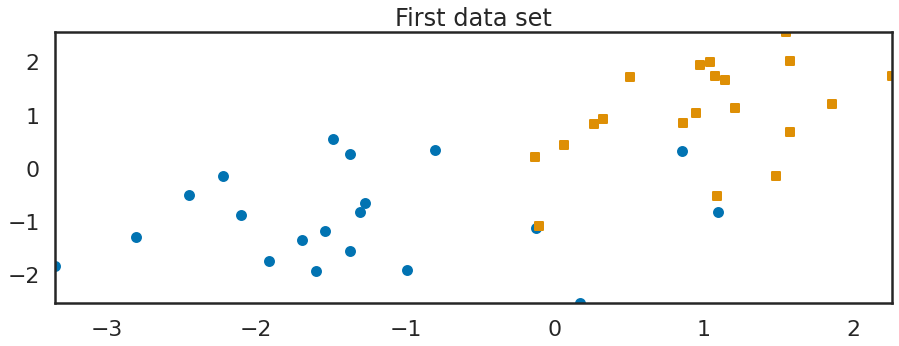

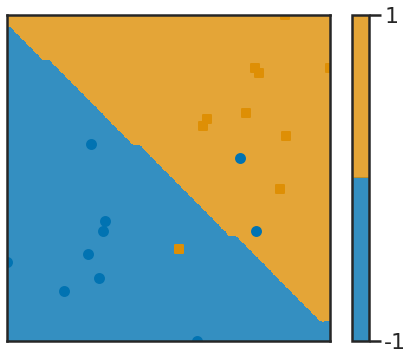

In [3]:
# This is an example of using SVC for data generated in the same way as the previous TP
n1 = 20
n2 = 20
mu1 = [1., 1.]
mu2 = [-1., -1.]
sigma1 = [0.9, 0.9]
sigma2 = [0.9, 0.9]
X1, y1 = rand_bi_gauss(n1, n2, mu1, mu2, sigma1, sigma2)

plt.show()
plt.close("all")
plt.ion()
plt.figure(1, figsize=(15, 5))
plt.title('First data set')
plot_2d(X1, y1)

X_train = X1[::2]
Y_train = y1[::2].astype(int)
X_test = X1[1::2]
Y_test = y1[1::2].astype(int)

# fit the model with linear kernel
clf = SVC(kernel='linear')
clf.fit(X_train, Y_train)

# predict labels for the test data base
y_pred = clf.predict(X_test)

# check your score
score = clf.score(X_test, Y_test)
print('Score : %s' % score)
# display the frontiere


def f(xx):
    """Classifier: needed to avoid warning due to shape issues"""
    return clf.predict(xx.reshape(1, -1))

plt.figure(2)
frontiere(f, X_train, Y_train, w=None, step=50, alpha_choice=1)

## Linear SVM

**3) Draw a i.i.d. sample from a mixture of two Gaussian distrtibutions : each class is a Gaussian with specific parameters. This time, use the function make_blobs available in sklearn.datasets library. Reserve 75% of the data for training and 25% for the test data.**

In [4]:
# draw iid Gaussian
n_samples = 100
std = np.array([[1, 1], [1, 1]])
centers = np.array([[0, 0],[3, 3]])

X, y = make_blobs(n_samples=n_samples, centers=centers, cluster_std=std, n_features=2, random_state=0)

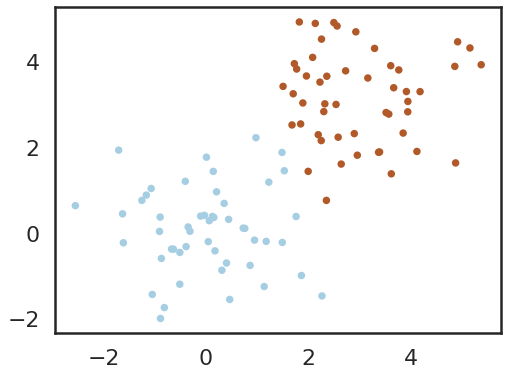

In [5]:
# scatter plot
plt.figure()
plt.scatter(X[:,0], X[:,1], c=y, s=30, cmap=plt.cm.Paired)

# separate into data and training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

**4) Since the probability distributions are known, numerically estimate the Bayes risk.**

In [6]:
# do a Monte-Carlo estimation of the Bayes Risk (given the gaussian distributions you used to generate data)

from scipy.stats import multivariate_normal

# function to calculate the Bayes Prediction
def bayes(X):
    
    l_y0 = multivariate_normal.pdf(X, mean=centers[0,:], cov=std[0,:]**2)
    l_y1 = multivariate_normal.pdf(X, mean=centers[1,:], cov=std[1,:]**2)

    p_y0 = np.divide((l_y0)*0.5, (l_y0*0.5 + l_y1*0.5))
    p_y1 = np.divide((l_y1)*0.5, (l_y0*0.5 + l_y1*0.5))

    # zero one loss
    h_bayes = 1*(p_y1 >= 0.5)
    return h_bayes

# calculate the Bayes Risk for the generated data
pred = bayes(X)
loss = 1*(pred != y)
bayes_risk = np.mean(loss)
print('Bayes risk:', bayes_risk)

Bayes risk: 0.03


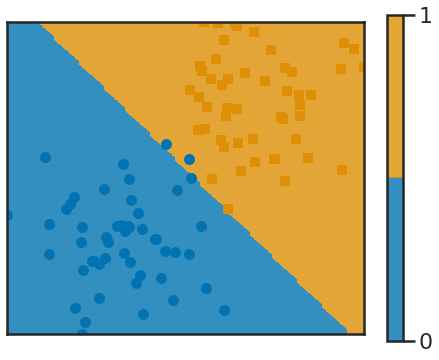

In [7]:
frontiere(bayes, X, y, step=100)

**5) Draw the decision boundary H induced by SVM as well as the hyperplanes H1 and H−1. Vary the parameter C to see its impact on the number of support vectors. We can use the example https://scikit-learn.org/stable/auto_examples/svm/plot_separating_hyperplane.html.**

In [8]:
def print_SVC(X_train, y_train, X_print, y_print, C, ax, kernel='linear', gamma='scale', degree=2):
    
    clf = svm.SVC(kernel=kernel, C=C, gamma=gamma, degree=degree)
    clf.fit(X_train, y_train)
    
    if kernel == 'rbf':
        ax.set_title('SVC %s - C: %.2f, G: %.2f' % (kernel, C, gamma) )
    elif kernel == 'poly':
        ax.set_title('SVC %s - C: %.2f, degree: %d' % (kernel, C, degree) )
    else:
        ax.set_title('SVC %s - C: %.2f' % (kernel, C) )
        
    ax.scatter(X_print[:, 0], X_print[:, 1], c=y_print, s=30, cmap=plt.cm.Paired)

    # plot the decision function
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # create grid to evaluate model
    xx = np.linspace(xlim[0], xlim[1], 100)
    yy = np.linspace(ylim[0], ylim[1], 100)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    Z = clf.decision_function(xy).reshape(XX.shape)

    # plot decision boundary and margins
    ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])

    # plot support vectors
    ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100,
               linewidth=1, facecolors='none', edgecolors='k')

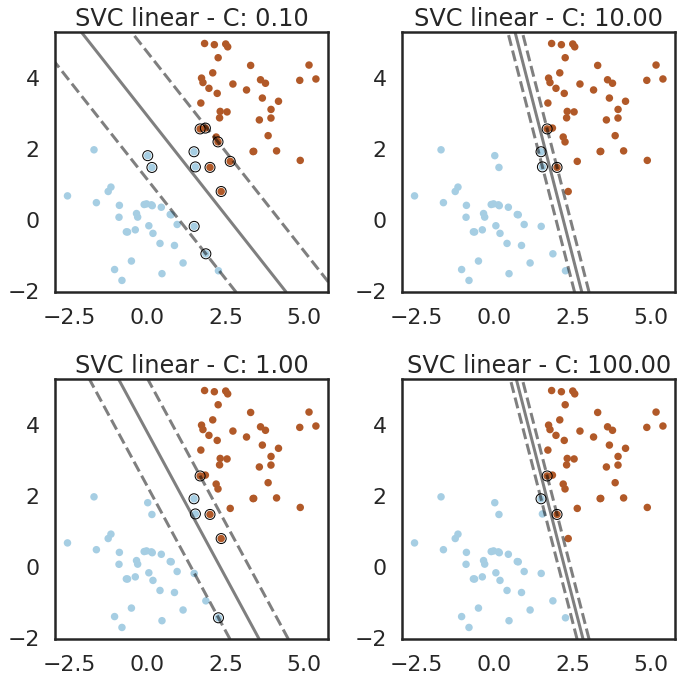

In [9]:
# print decision boundaries for different values of C
fig, ax = plt.subplots(2, 2, figsize=(10,10))

C = [0.1, 1, 10, 100]
kernel = 'linear'

for i in range(len(C)):
    
    print_SVC(X_train, y_train, X_train, y_train, C[i], ax=ax[i%2, i//2], kernel=kernel)
    
plt.tight_layout()
plt.show()

**6) Define the Gaussian classes such that the two distributions overlap. Draw an i.i.d. sample from the joint probability distribution. Apply a 5-fold Cross-Validation to find the optimal parameter C∗ to classify this new dataset using a linear kernel.**

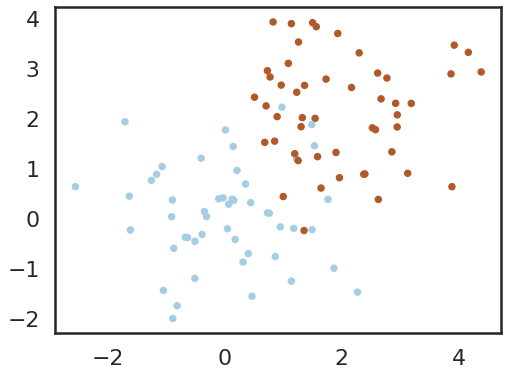

In [10]:
# generate data and verify graphically that the two classes overlap
n_samples = 100
std = np.array([[1, 1],[1, 1]])
centers = np.array([[0, 0],[2, 2]])

X, y = make_blobs(n_samples=n_samples, centers=centers, cluster_std=std, n_features=2, random_state=0)
plt.figure()
plt.scatter(X[:,0], X[:,1], c=y, s=30, cmap=plt.cm.Paired)
plt.show()

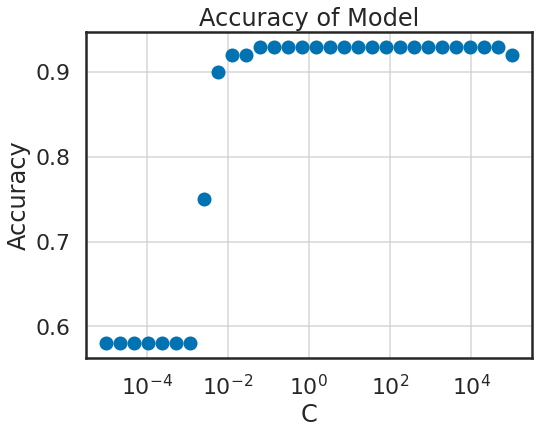

In [11]:
# Find the best working C with a 5-fold cross-validation

from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score

# generate cross validation sets
cv = RepeatedKFold(n_splits=5, n_repeats=1, random_state=0)

# generate hyperparameters spaces
C = np.logspace(-5, 5, 30)

mean_scores = []
for i in range(len(C)):
    model = svm.SVC(kernel='linear', C=C[i])
    
    # evaluate model
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    mean_scores.append(np.mean(scores))

# plot results
plt.figure()
plt.title('Accuracy of Model')
plt.ylabel('Accuracy')
plt.xlabel('C')
plt.scatter(C, mean_scores)
plt.xscale('log')
plt.grid(alpha=0.6)
plt.show()

In [12]:
# print optimum C value
accuracy = max(mean_scores)
C_opt = C[np.argmax(mean_scores)]

print('Best Score:', accuracy, 'with C =', C_opt)

Best Score: 0.93 with C = 0.06210169418915616


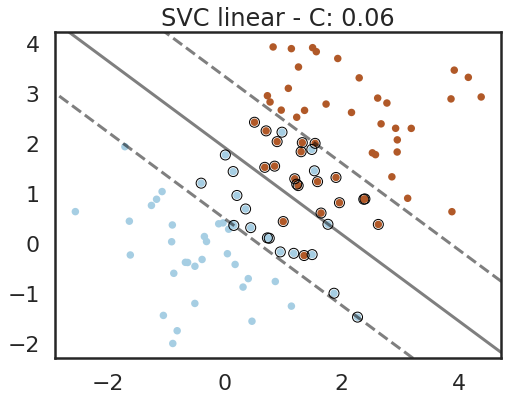

In [13]:
# plot results
fig, ax = plt.subplots()
print_SVC(X, y, X, y, C_opt, ax, kernel='linear')
plt.show()

**7) Show how tuning SVM hyperparameters on training data, for example by taking a Gaussian kernel (the parameters are therefore gamma and C), can lead to overfitting.**

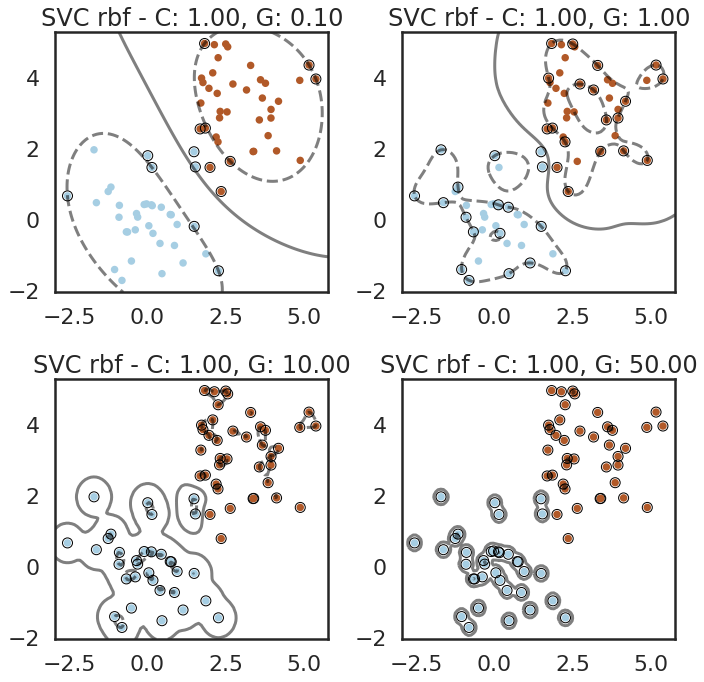

In [14]:
# vary the parameter of the kernel and check the difference between training and testing scores

fig, ax = plt.subplots(2, 2, figsize=(10,10))

C = [1]
gammas = [0.1, 1, 10, 50]
kernel = 'rbf'

for j in range(len(C)):
    for i in range(len(gammas)):

        print_SVC(X_train, y_train, X_train, y_train, C[j], ax=ax[(j*2+i)//2, (i+j*2)%2], kernel=kernel, gamma=gammas[i])
    
plt.tight_layout()
plt.show()

We can see that, for a fixed regularization parameter, increasing Gamma in the Gaussian SVM Model will lead to overfitting of the training data (as we can see in the bottom-right corner plot). The model is clearly giving a very overfitted estimate of the boundaries, assigning each point almost individually to one of the classes. In this extreme case, we can infer that by adding new, unseen data, drawn from the same distributions, the model will not perform well, since it is prone to predicting extreme results that only apply for the initial training set. 

Visually, the model that probably performs the best is the one in the top-right corner (Gamma = 1), where the decision boundary fits the training data well, but still allow for natural deviation present in the data.

## Non linear SVM

**8) Define a new binary nonlinear classification problem : for instance, define one class as a Gaussian surrounded by the other chosen as a circle class, or choose the second class as a mixture of two Gaussian in such way that the separation problem is nonlinear. Generate a non-linearly separable dataset (we could for example use the function make_blobs available in sklearn.datasetslibrary ).**

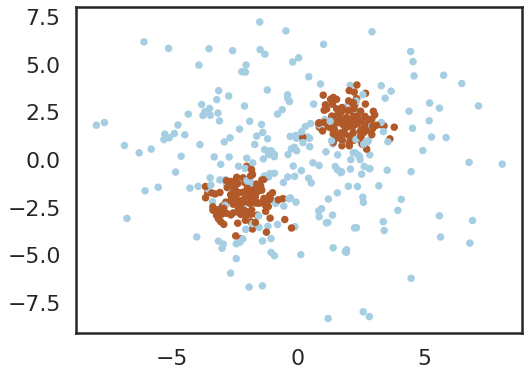

In [15]:
n_samples = 500
std = np.array([[3, 3], [3, 3], [0.7, 0.7], [0.7, 0.7]])
centers = np.array([[0, 0],[0, 0],[-2, -2], [2, 2]])

# generate data non linearly separable
X, y = make_blobs(n_samples=n_samples, centers=centers, cluster_std=std, n_features=2, random_state=0)
y[y==1]=0
y[y==2]=1
y[y==3]=1

plt.figure()
plt.scatter(X[:,0], X[:,1], c=y, s=30, cmap=plt.cm.Paired)
plt.show()

**9) Use an SVM with a Gaussian kernel then a polynomial (with well-adapted parameters) then plot the decision boundaries of these algorithms on separate graphs.**

In [16]:
import itertools as it
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
hyperparams = {}

In [17]:
# Optimizing Gaussian Kernel Parameters with cross-validation

# generate cross validation sets
cv = RepeatedKFold(n_splits=5, n_repeats=1, random_state=0)

# generate hyperparameters spaces
C = np.logspace(-5, 2, 10)
gammas = np.logspace(-5, 2, 10)

# linear search for best hyper parameters
best_score = 0
for _,(c, gamma) in enumerate(it.product(C, gammas)):
    model = svm.SVC(kernel='rbf'
                    , C=c, gamma=gamma)
    
    # evaluate model
    scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
    score = np.mean(scores)
    
    if score > best_score:
        best_score = score
        C_opt = c
        gamma_opt = gamma

# store and print results
hyperparams['gaussian'] = {'C_opt': C_opt, 'gamma_opt': gamma_opt}
print('Gaussian Best Score:', best_score, 'with C =', C_opt, ', gamma =', gamma_opt)

Gaussian Best Score: 0.8693333333333333 with C = 0.0774263682681127 , gamma = 0.4641588833612782


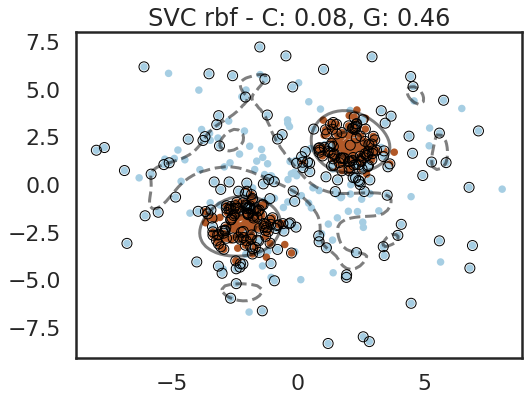

In [18]:
# plotting fitted model
fig, ax = plt.subplots()
print_SVC(X_train, y_train, X, y, C_opt, ax, kernel='rbf', gamma=gamma_opt)
plt.show()

In [19]:
# Optimizing Poly Kernel Parameters with cross-validation

# generate cross validation sets
cv = RepeatedKFold(n_splits=5, n_repeats=1, random_state=0)

# generate hyperparameters spaces
C = np.logspace(-2, 3, 10)
degrees = range(1,7)

# linear search for best hyper parameters
best_score = 0
for _,(c, degree) in enumerate(it.product(C, degrees)):
    model = svm.SVC(kernel='poly', C=c, degree=degree)
    
    # evaluate model
    scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
    score = np.mean(scores)
    
    if score > best_score:
        best_score = score
        C_opt = c
        degree_opt = degree

# store and print results
hyperparams['poly'] = {'C_opt': C_opt, 'degree_opt': degree_opt}
print('Poly Best Score:', best_score, 'with C =', C_opt, ', degree =', degree_opt)

Poly Best Score: 0.8026666666666668 with C = 77.42636826811278 , degree = 2


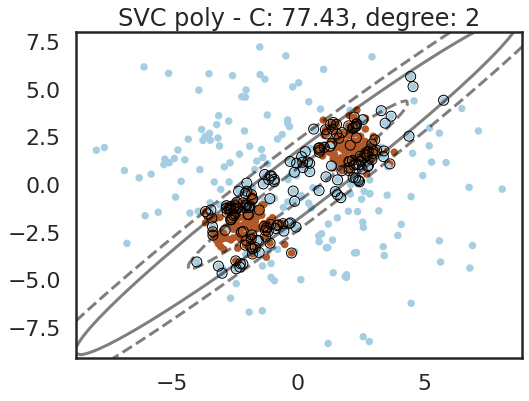

In [20]:
# plotting fitted model
fig, ax = plt.subplots()
print_SVC(X_train, y_train, X, y, C_opt, ax, kernel='poly', degree=degree_opt)
plt.show()

**10) We wish to compare classification performance between different SVMs based on different kernels
(linear, polynomial and Gaussian). Propose a method allowing to compare these three algorithms.**

One way to select the best performing model is performing a line-search to find the optimal hyperparameters through cross-validation in the train set for each different kernel. After finding the optimal parameters, we can obtain the test accuracy for each kernel and select the model with the highest accuracy. Since the dataset is not linearly separable, we will only consider the cases where the Kernel is non-linear (Gaussian and Polynomial).

In [21]:
# fit and calculate accuracy for gaussian model
gaussian_model = svm.SVC(kernel='rbf', C=hyperparams['gaussian']['C_opt'], gamma=hyperparams['gaussian']['gamma_opt'])
gaussian_model.fit(X_train, y_train)
gaussian_score = gaussian_model.score(X_test, y_test)

# fit and calculate accuracy for polynomial model
poly_model = svm.SVC(kernel='poly', C=hyperparams['poly']['C_opt'], degree=hyperparams['poly']['degree_opt'])
poly_model.fit(X_train, y_train)
poly_score = poly_model.score(X_test, y_test)

# print results
print('Gaussian Kernel Test Score:', gaussian_score)
print('Poly Kernel Test Score:', poly_score)

Gaussian Kernel Test Score: 0.856
Poly Kernel Test Score: 0.752


We can see that for the generated data, the Gaussian Kernel reached a better accuracy. Therefore, we will select it as the better performing model.

**11) Draw the learning curve of the algorithm : with fixed hyper-parameters and fixed test set, calculate the training and test errors by using training sub-sets of training data of various sizes (drawn randomly). Plot the train and test error based on the size of the train set subset. Estimate and display the accuracy of the Bayes predictor on the same graph. Comment.**

First, let's build functions to estimate the Bayes Risk in a set of data given that we know their distributions.

In [22]:
# function to calculate Bayes prediction
def bayes_pred(X):
    
    l_y0 = multivariate_normal.pdf(X, mean=centers[0,:], cov=std[0,:]**2)
    l_y0 += multivariate_normal.pdf(X, mean=centers[1,:], cov=std[1,:]**2)
    l_y1 = multivariate_normal.pdf(X, mean=centers[2,:], cov=std[2,:]**2)
    l_y1 += multivariate_normal.pdf(X, mean=centers[3,:], cov=std[3,:]**2)
    
    p_y0 = np.divide((l_y0)*0.5, (l_y0*0.5 + l_y1*0.5))
    p_y1 = np.divide((l_y1)*0.5, (l_y0*0.5 + l_y1*0.5))

    # zero one loss
    h_bayes = 1*(p_y1 >= 0.5)
    
    return h_bayes

# function to calculate Bayes accuracy
def bayes_acc(pred, y):
    num_errors = np.sum(1*(pred != y))
    acc = num_errors/len(pred)

    if acc < 0.5:
        return 1-acc
    else:
        return acc

We can see how the Bayes estimator classifies the training data in the following image.

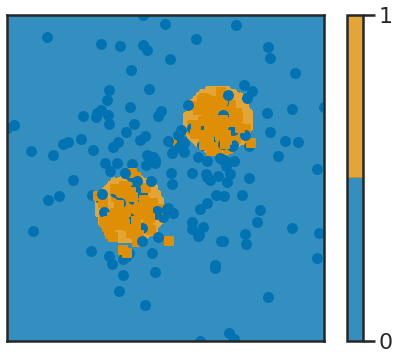

In [23]:
frontiere(bayes_pred, X_train, y_train, step=100)

Now, we estimate the SVM train and test accuracy for the best estimator (selected in previous question: Gaussian) as well as the Bayes Risk for different training data sample sizes. Note: to obtain a better estimate of the accuracy, we calculate the average accuracy over 5 iterations of randomly drawn data with the same size.

In [24]:
# set different sizes and number of iterations for each size
sizes = np.arange(100, X_train.shape[0]+1, 50)
num_iter = 5

# initialize score vectors
train_scores = []
test_scores = []
bayes_scores = []

# for all sizes, obtain an estimate of the error by averaging over a defined number of iterations
for size in sizes:
    train_score = 0
    test_score = 0
    bayes_score = 0
    
    for i in range(num_iter):
        
        # draw data randomly with different sizes
        mask = np.random.choice(np.arange(len(X_train)), size, replace=False)
        X_use = X_train[mask]
        y_use = y_train[mask]

        # initialize and fit model
        gaussian_model = svm.SVC(kernel='rbf', C=hyperparams['gaussian']['C_opt'], gamma=hyperparams['gaussian']['gamma_opt'])
        gaussian_model.fit(X_use, y_use)
    
        # obtain train, test and bayes score for randomly drawn data
        train_score += gaussian_model.score(X_use, y_use)
        test_score += gaussian_model.score(X_test, y_test)
        bayes_score += bayes_acc(bayes_pred(X_use), y_use)
    
    # store scores
    train_scores.append(train_score/num_iter)
    test_scores.append(test_score/num_iter)
    bayes_scores.append(bayes_score/num_iter)

Plotting the results.

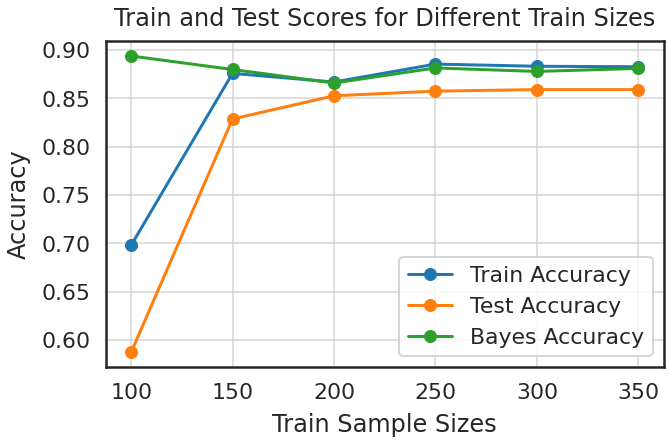

In [25]:
plt.figure(figsize=(10,6))
plt.plot(sizes, train_scores, '-o', c='tab:blue') 
plt.plot(sizes, test_scores, '-o', c='tab:orange')
plt.plot(sizes, bayes_scores, '-o', c='tab:green')
plt.title('Train and Test Scores for Different Train Sizes', pad=15)
plt.xlabel('Train Sample Sizes', labelpad=10)
plt.ylabel('Accuracy', labelpad=10)
plt.legend(['Train Accuracy', 'Test Accuracy', 'Bayes Accuracy'])
plt.grid(alpha=0.6)
plt.show()

**12) Add noise to the dataset by randomly modifying the labels of some training data. Then, draw the complexity curves of the algorithm : with set train and test set, draw the train and test error as a function of the complexity (i.e. as a function of the value of the hyper-parameter controlling the complexity, or the number of support vector). Comment.**


First, let's create a function to add noise to a specified percentage of random training labels.

In [26]:
# Function to generate noise in label data. Switches a random_pct percentage of labels in y_train.
def gen_y_noise(random_pct):

    random_choice = np.random.choice(np.arange(len(X_train)), round(random_pct*len(X_train)), replace=False)
    
    y_train_noise = y_train[:]
    for i in random_choice:
        if y_train[i] == 0:
            y_train_noise[i] = 1
        else:
            y_train_noise[i] = 0
    
    return y_train_noise

Now, let's train different models on training data that contains noise with different model complexities. For each complexity, we train 10 different models varying the noise on the y data (for different % of switched training labels) and we collect the average train and test accuracy for each complexity value.

In [27]:
def noise_accuracy(noise_pct):
    """
    Function to calculate and plot the train and test loss for a RBF SVM with varying levels of complexity
    and noise percentage.
    """
    
    # initialize complexity and number of iterations to average the scores
    nus = np.linspace(0.15, 0.85, 20)
    num_iter = 10
    
    # initialize scores vectors
    train_scores = []
    test_scores = []
    
    # calculating accuracy
    for nu in nus:
        train_score = 0
        test_score = 0
        for _ in range(num_iter):
            model = svm.NuSVC(kernel='rbf', nu=nu, gamma='auto')

            y_train_noise = gen_y_noise(noise_pct)
            model.fit(X_train, y_train_noise)

            train_score += model.score(X_train, y_train_noise)
            test_score += model.score(X_test, y_test)

        train_scores.append(train_score/num_iter)
        test_scores.append(test_score/num_iter)
    
    # plotting results
    plt.figure(figsize=(10,6))
    plt.plot(nus, train_scores, '-o', c='tab:blue') 
    plt.plot(nus, test_scores, '-o', c='tab:orange')
    plt.title(f'Train and Test Scores for Different Complexities - {noise_pct*100}% of Noise', pad=15)
    plt.xlabel('Complexity', labelpad=10)
    plt.ylabel('Accuracy', labelpad=10)
    plt.legend(['Train Accuracy', 'Test Accuracy'])
    plt.grid(alpha=0.6)
    plt.show()

Plotting the results.

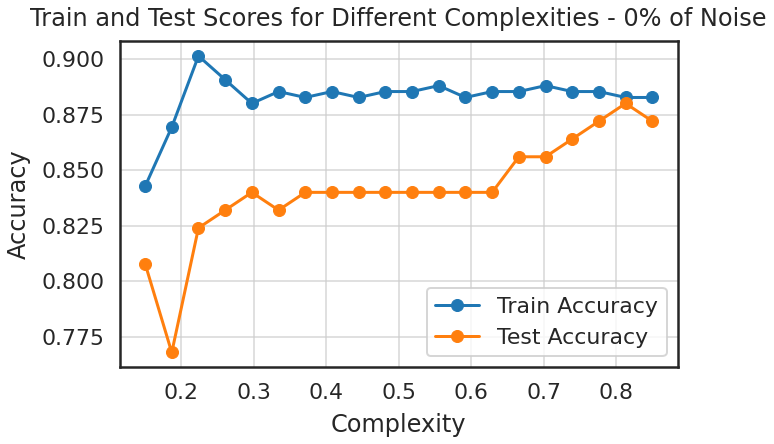

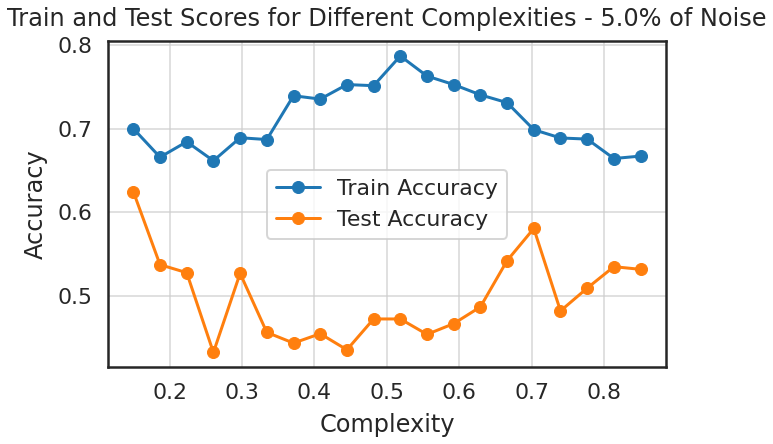

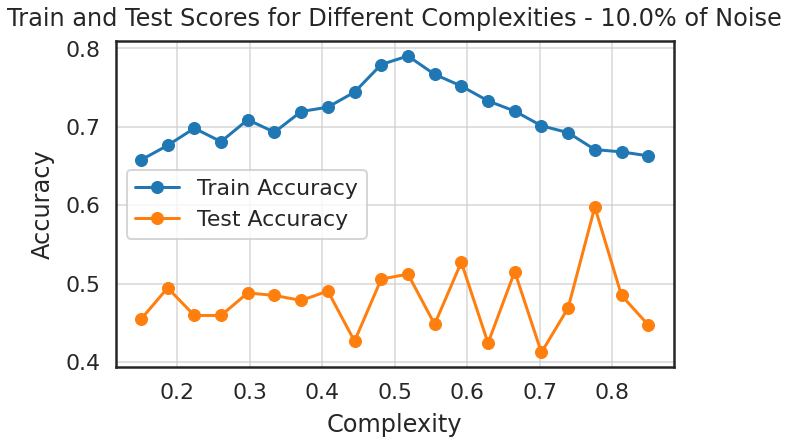

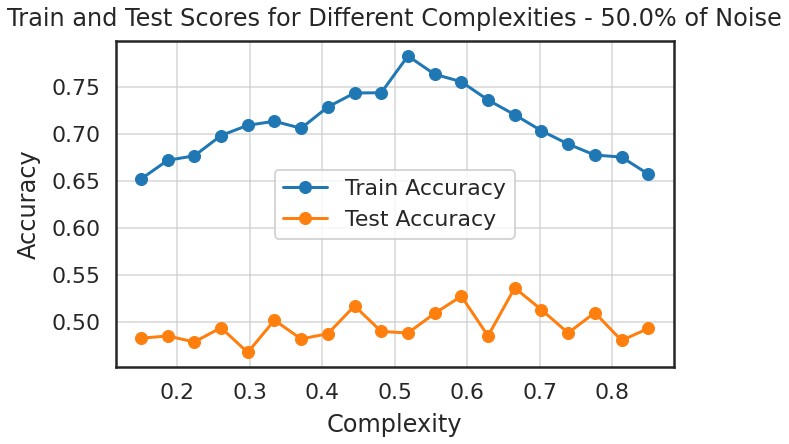

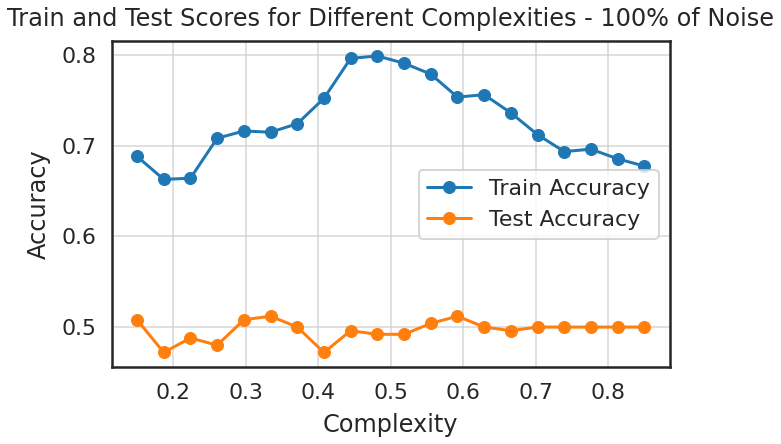

In [28]:
# estimate train and test loss for varying levels of noise pct
noises = [0, 0.05, 0.1, 0.5, 1]

for noise in noises:
    noise_accuracy(noise)

We can see that since some labels contain noise, training accuracy is usually much higher than test accuracy (in fact, when 100% of labels are switched, test accuracy tends to 50%, which is the same as randomly choosing). We can also see that test scores are not directly proportional to complexity - there is an optimal point that optimizes test accuracy, usually around 0.5.

## SVM GUI

**13) Start the script svm_gui.py available at the link : http://scikit-learn.org/stable/auto_examples/applications/svm_gui.html
This application allows real-time evaluation of the impact the choice of the kernel and the regularization parameter C.**

**14) Generate a very unbalanced data set with much more points in one class than in the other (at least
90% vs 10%)**

**15) Using a linear kernel and decreasing the parameter C what do you observe ?**

The parameter C represents the regularization penalty, therefore, increasing this parameter means that the model will penalize misclassifications with a higher cost. As we decrease C, the cost of a misclassification becomes negligible, and the model will only try to maximize $||w||$. Since our dataset is highly unbalanced, this means pushing the dividing hyperplan further away from the dominant class, until all data points are predicted as the dominant class (which in our case will still yield a 90% accuracy).

## Going further : application to face classification

Code for downloading and organizing the data:

In [29]:
###############################################################################
#               Face Recognition Task
###############################################################################
"""
The dataset used in this example is a preprocessed excerpt
of the "Labeled Faces in the Wild", aka LFW_:

  http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz (233MB)

  _LFW: http://vis-www.cs.umass.edu/lfw/

"""

from time import time
import pylab as pl
from sklearn.datasets import fetch_lfw_people


####################################################################
# Download the data (if not already on disk); load it as numpy arrays
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4,
                              color=True, funneled=False, slice_=None,
                              download_if_missing=True)
# data_home='.'

# introspect the images arrays to find the shapes (for plotting)
images = lfw_people.images / 255.
n_samples, h, w, n_colors = images.shape

# the label to predict is the id of the person
target_names = lfw_people.target_names.tolist()

####################################################################
# Pick a pair to classify such as
names = ['Tony Blair', 'Colin Powell']
# names = ['Donald Rumsfeld', 'Colin Powell']

idx0 = (lfw_people.target == target_names.index(names[0]))
idx1 = (lfw_people.target == target_names.index(names[1]))
images = np.r_[images[idx0], images[idx1]]
n_samples = images.shape[0]
y = np.r_[np.zeros(np.sum(idx0)), np.ones(np.sum(idx1))].astype(np.int)

####################################################################
# Extract features

# features using only illuminations
X = (np.mean(images, axis=3)).reshape(n_samples, -1)

# or compute features using colors (3 times more features)
# X = images.copy().reshape(n_samples, -1)

# Scale features
X -= np.mean(X, axis=0)
X /= np.std(X, axis=0)

####################################################################
# Split data into a half training and half test set
# X_train, X_test, y_train, y_test, images_train, images_test = \
#    train_test_split(X, y, images, test_size=0.5, random_state=0)
# X_train, X_test, y_train, y_test = \
#    train_test_split(X, y, test_size=0.5, random_state=0)

indices = np.random.permutation(X.shape[0])
train_idx, test_idx = indices[:int(X.shape[0] / 2)], indices[int(X.shape[0] / 2):]
X_train, X_test = X[train_idx, :], X[test_idx, :]
y_train, y_test = y[train_idx], y[test_idx]
images_train, images_test = images[train_idx, :, :, :], images[test_idx, :, :, :]

**16) By modifying the following code, show the influence of the regularization parameter. For example, the prediction error can be displayed as a function of C on a logarithmic scale between 1e5 and 1e-5.**

Fitting the classifier to the training set


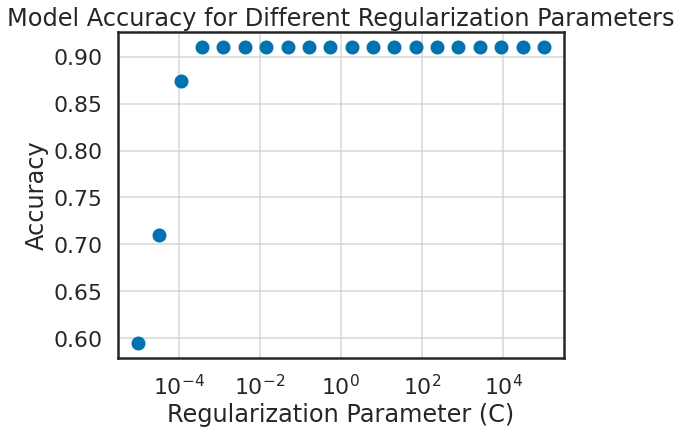

done in 14.992s


In [30]:
# Quantitative evaluation of the model quality on the test set
print("Fitting the classifier to the training set")
t0 = time()

C = np.logspace(-5, 5, 20)
scores = []

# linear search for the best hyperparameters
for c in C:

    clf = svm.SVC(kernel="linear", C=c)
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    scores.append(score)

# plot results
plt.figure()
plt.scatter(C, scores)
plt.xscale('log')
plt.grid(alpha=0.6)
plt.title('Model Accuracy for Different Regularization Parameters')
plt.xlabel('Regularization Parameter (C)')
plt.ylabel('Accuracy')
plt.show()
print("done in %0.3fs" % (time() - t0))

In [31]:
# Optimizing Parameters with cross-validation

# generate cross validation sets
cv = RepeatedKFold(n_splits=5, n_repeats=1, random_state=0)

# generate hyperparameters spaces
C = np.logspace(-5, 5, 20)

# linear search for best hyper parameters
best_score = 0
for c in C:
    model = svm.SVC(kernel='linear', C=c)
    
    # evaluate model
    scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
    score = np.mean(scores)
    
    if score > best_score:
        best_score = score
        C_opt = c
        gamma_opt = gamma

print('Best Cross-Val Score:', best_score, 'with C =', C_opt)

Best Cross-Val Score: 0.9210526315789472 with C = 0.0012742749857031334


In [32]:
# fit model with optimal parameters
clf = svm.SVC(kernel='linear', C=C_opt)
clf.fit(X_train, y_train)

print("Predicting the people names on the testing set")
t0 = time()

# predict labels for the X_test images
y_pred = clf.predict(X_test)

print("done in %0.3fs" % (time() - t0))
print("Chance level : %s" % max(np.mean(y), 1. - np.mean(y)))
print("Accuracy : %s" % clf.score(X_test, y_test))

Predicting the people names on the testing set
done in 0.287s
Chance level : 0.6210526315789474
Accuracy : 0.9105263157894737


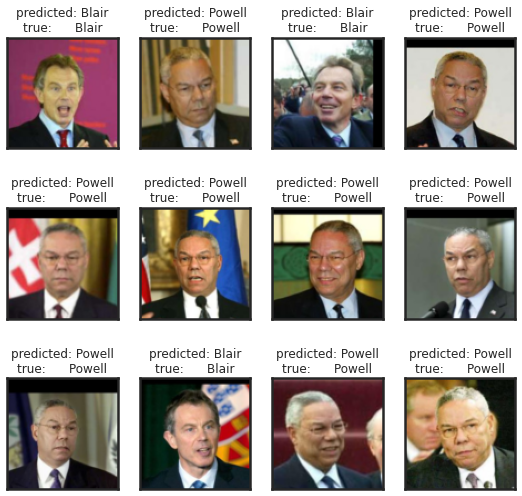

In [33]:
####################################################################
# Qualitative evaluation of the predictions using matplotlib

def plot_gallery(images, titles, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    pl.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    pl.subplots_adjust(bottom=0, left=.01, right=.99, top=.90,
                       hspace=.35)
    for i in range(n_row * n_col):
        pl.subplot(n_row, n_col, i + 1)
        pl.imshow(images[i])
        pl.title(titles[i], size=12)
        pl.xticks(())
        pl.yticks(())


def title(y_pred, y_test, names):
    pred_name = names[int(y_pred)].rsplit(' ', 1)[-1]
    true_name = names[int(y_test)].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

prediction_titles = [title(y_pred[i], y_test[i], names)
                     for i in range(y_pred.shape[0])]

plot_gallery(images_test, prediction_titles)
pl.show()

**17) By adding nuisance variables, thus increasing the number of variables to the number of learning points fixed, show that performance drops.**

To compare model performance, we're going to compute features using colors, which will lead to a 3 fold increase in the number of features. Then, we're going to optimize the model's hyperparameters using cross-validation and compute the test score.

In [34]:
# compute features using colors (3 times more features)
X = images.copy().reshape(n_samples, -1)

# Scale features
X -= np.mean(X, axis=0)
X /= np.std(X, axis=0)

# split into train test data
indices = np.random.permutation(X.shape[0])
train_idx, test_idx = indices[:int(X.shape[0] / 2)], indices[int(X.shape[0] / 2):]
X_train, X_test = X[train_idx, :], X[test_idx, :]
y_train, y_test = y[train_idx], y[test_idx]
images_train, images_test = images[train_idx, :, :, :], images[test_idx, :, :, :]

In [35]:
# Optimizing Parameters with cross-validation

# generate cross validation sets
cv = RepeatedKFold(n_splits=5, n_repeats=1, random_state=0)

# generate hyperparameters spaces
C = np.logspace(-5, 5, 5)

# linear search for best hyper parameters
best_score = 0
for c in C:
    model = svm.SVC(kernel='linear', C=c)
    
    # evaluate model
    scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
    score = np.mean(scores)
    
    if score > best_score:
        best_score = score
        C_opt = c
        gamma_opt = gamma

print('Best Cross-Val Score:', best_score, 'with C =', C_opt)

Best Cross-Val Score: 0.9052631578947368 with C = 0.0031622776601683794


In [36]:
# fit model with optimal parameters
clf = svm.SVC(kernel='linear', C=C_opt)
clf.fit(X_train, y_train)

print("Predicting the people names on the testing set")
t0 = time()

# predict labels for the X_test images
y_pred = clf.predict(X_test)

print("done in %0.3fs" % (time() - t0))
print("Chance level : %s" % max(np.mean(y), 1. - np.mean(y)))
print("Accuracy : %s" % clf.score(X_test, y_test))

Predicting the people names on the testing set
done in 1.178s
Chance level : 0.6210526315789474
Accuracy : 0.8894736842105263


We can see that the model test accuracy did not change much (depends on the randomness of the train/test split). However, the time performance is significantly worse, since it takes almost three times more to predict peoples names in the testing set (approximately 0.9s with color features versus 0.3s using only illuminations).

**18) Explain why the features are centered and reduced.**

Since linear SVMs try to find the minimum hyperplane vector $w$, the scale of the features will affect the norm of $w$. Therefore, not standardizing the data means that some features are more sensitive to the regularization parameter than others, because they have different scales. Also, if features have varying and/or large values, they can become more/less sensitive to the regularization parameter, which makes parameter calibration harder. Thus, it is better to standardize data to enforce homogeneous regularization.

**19) What is the effect of choosing a non-linear RBF kernel on prediction? You will be able to improve the prediction with a reduction of dimension based on the object sklearn.decomposition.RandomizedPCA.**

First, we will optimize an RBF Kernel SVM model for C and Gamma through cross-validation. We will still use the full featured data, with 30000 features.

In [37]:
# Optimizing RBF Kernel Parameters with cross-validation

# generate cross validation sets
cv = RepeatedKFold(n_splits=5, n_repeats=1, random_state=0)

# generate hyperparameters spaces
C = np.logspace(-2, 3, 5)
gammas = np.logspace(-7, 1, 5)

# linear search for best hyper parameters
best_score = 0
for _,(c, gamma) in enumerate(it.product(C, gammas)):
    model = svm.SVC(kernel='rbf', C=c, gamma=gamma)
    
    # evaluate model
    scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
    score = np.mean(scores)
    
    if score > best_score:
        best_score = score
        C_opt = c
        gamma_opt = gamma

print('RBF Best Score:', best_score, 'with C =', C_opt, ', gamma =', gamma_opt)

RBF Best Score: 0.9052631578947368 with C = 1000.0 , gamma = 1e-07


In [38]:
# fit model with optimal parameters
clf = svm.SVC(kernel='rbf', C=C_opt, gamma=gamma_opt)
clf.fit(X_train, y_train)

print("Predicting the people names on the testing set")
t0 = time()

# predict labels for the X_test images
y_pred = clf.predict(X_test)

print("done in %0.3fs" % (time() - t0))
print("Chance level : %s" % max(np.mean(y), 1. - np.mean(y)))
print("Accuracy : %s" % clf.score(X_test, y_test))

Predicting the people names on the testing set
done in 0.954s
Chance level : 0.6210526315789474
Accuracy : 0.8947368421052632


We can see that the accuracy, as well as the time consumed to predict names on the testing set don't change much when compared to the Linear Kernel SVM. However, training becomes much harder, since we have to optimize two hyperparameters instead of one, and also RBF SVM optimization's operations take more time.

Now, let's apply PCA to reduce the feature dimensionality.

In [39]:
from sklearn.decomposition import PCA as RandomizedPCA

pca = RandomizedPCA()
pca.fit(X_train)
X_train_pca = pca.transform(X_train)

And now optimize the RBF Kernel using reduced feature training data.

In [40]:
# Optimizing RBF Kernel Parameters with cross-validation

# generate cross validation sets
cv = RepeatedKFold(n_splits=5, n_repeats=1, random_state=0)

# generate hyperparameters spaces
C = np.logspace(-2, 3, 5)
gammas = np.logspace(-7, 1, 5)

# linear search for best hyper parameters
best_score = 0
for _,(c, gamma) in enumerate(it.product(C, gammas)):
    model = svm.SVC(kernel='rbf', C=c, gamma=gamma)
    
    # evaluate model
    scores = cross_val_score(model, X_train_pca, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
    score = np.mean(scores)
    
    if score > best_score:
        best_score = score
        C_opt = c
        gamma_opt = gamma

print('RBF Best Score:', best_score, 'with C =', C_opt, ', gamma =', gamma_opt)

RBF Best Score: 0.9052631578947368 with C = 1000.0 , gamma = 1e-07


In [41]:
# fit model with optimal parameters
clf = svm.SVC(kernel='rbf', C=C_opt, gamma=gamma_opt)
clf.fit(X_train_pca, y_train)

print("Predicting the people names on the testing set")
t0 = time()

# predict labels for the X_test images
y_pred = clf.predict(pca.transform(X_test))

print("done in %0.3fs" % (time() - t0))
print("Chance level : %s" % max(np.mean(y), 1. - np.mean(y)))
print("Accuracy : %s" % clf.score(pca.transform(X_test), y_test))

Predicting the people names on the testing set
done in 0.034s
Chance level : 0.6210526315789474
Accuracy : 0.8947368421052632


We can see that the accuracy did not change, since the PCA is set to explain all the variance in the input data. However, the time performance is a lot better when PCA is applied, because training and predicting become a lot faster due to the reduction of the dimensions of the data. This happens mainly because the dimension of the feeatures are much bigger than the dimension of the number of samples. Otherwise, this type of dimensionality reduction would also include a loss in the information contained in the data.